In [1]:
import json
import os
from glob import glob

import numpy as np
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.preprocess_data import get_data_properties
from EmbedSeg.utils.visualize import visualize_crop_3d
from matplotlib.colors import ListedColormap
from tqdm import tqdm

### Calculate some dataset specific properties 

In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. <br>
We will also specify some properties, for example,  

* set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and 
    `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

Lastly, we will save the dictionary `data_properties_dir` in a json file, which we will access in the `02-train` and `03-predict` notebooks.

In [2]:
data_dir = "/cluster/project/treutlein/DATA/imaging/EmbedSeg_test/data/"
project_name = "3D_Brain_organoids_with_meta"
run_name = "all_06_02_2023"

In [3]:
data_properties_dir = get_data_properties(
    data_dir,
    project_name,
    train_val_name=["train", "val"],
    test_name=["test"],
    mode="3d",
)

data_properties_dir["data_type"] = "16-bit"
data_properties_dir["pixel_size_x_microns"] = (
    0.347 * 2
)  # set equal to voxel size (microns) in x dimension
data_properties_dir["pixel_size_y_microns"] = (
    0.347 * 2
)  # set equal to voxel size (microns) in y dimension
data_properties_dir["pixel_size_z_microns"] = (
    2.0  # set equal to voxel size (microns) in z dimension
)

# set the following to the region which shouldn't be considered during evaluation.
# If the entire evaluation image was annotated, then comment the next six lines!
# data_properties_dir['mask_start_x']= 231
# data_properties_dir['mask_end_x']= 408
# data_properties_dir['mask_start_y']= 0
# data_properties_dir['mask_end_y']= 152
# data_properties_dir['mask_start_z']= 51
# data_properties_dir['mask_end_z']= 72


with open(f"data_properties_{run_name}.json", "w") as outfile:
    json.dump(data_properties_dir, outfile)
    print(
        "Dataset properies of the `{}` dataset is saved to `data_properties.json`".format(
            project_name
        )
    )

100%|██████████| 72/72 [00:07<00:00, 10.12it/s]


Foreground weight of the `3D_Brain_organoids_with_meta` dataset set equal to 48.009


100%|██████████| 72/72 [01:37<00:00,  1.36s/it]


Minimum object size of the `3D_Brain_organoids_with_meta` dataset is equal to 1
Mean object size of the `3D_Brain_organoids_with_meta` dataset is equal to 2087.5304273504275
Maximum object size of the `3D_Brain_organoids_with_meta` dataset is equal to 10610
Average object size of the `3D_Brain_organoids_with_meta` dataset along `x` is equal to 25.333
Std. dev object size of the `3D_Brain_organoids_with_meta` dataset along `x` is equal to 15.180
Average object size of the `3D_Brain_organoids_with_meta` dataset along `y` is equal to 26.001
Std. dev object size of the `3D_Brain_organoids_with_meta` dataset along `y` is equal to 15.584
Average object size of the `3D_Brain_organoids_with_meta` dataset along `z` is equal to 8.188
Std. dev object size of the `3D_Brain_organoids_with_meta` dataset along `z` is equal to 5.281


100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Tile size of the `3D_Brain_organoids_with_meta` dataset set equal to  (n_z = 64, n_y = 304, n_x = 304)


100%|██████████| 72/72 [00:04<00:00, 16.68it/s]

Average background intensity of the `3D_Brain_organoids_with_meta` dataset set equal to 21.728
Dataset properies of the `3D_Brain_organoids_with_meta` dataset is saved to `data_properties.json`


### Specify desired centre location for spatial embedding of pixels

Interior pixels of an object instance can either be embedded at the `centroid` (evaluated in $\mathcal{O(n)}$ operations, where $\mathcal{n}$ is the number of pixels in an object instance), or the `medoid` (evaluated in $\mathcal{O(n^{2})}$ operations). Please note that evaluating `medoid` of the instances could be slow especially if you choose a large `crop_size` later: in such a scenario, a quicker alternative is opting for a higher <b><a href='#speed_up'>`speed_up`</a></b> factor.

In [4]:
center = "medoid"  # 'medoid', 'centroid'
try:
    assert center in {"medoid", "centroid"}
    print("Spatial Embedding Location chosen as : {}".format(center))
except AssertionError as e:
    e.args += ('Please specify center as one of : {"medoid", "centroid"}', 42)
    raise

Spatial Embedding Location chosen as : medoid


### Specify cropping configuration parameters

Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook). Here, `data_subset` defines the directory which is processed. 

Note that we automatically calculate  the `crop_size` by using the `avg_object_size` and `std_object_size` through the relation:
$\text{crop_size_i} = \text{avg_obj_size_i} + \text{n_sigma} \times \text{std_obj_size_i}$ where $i \in \{x,y,z\}$ and `n_sigma` equals `5` by default.

Please feel free to reduce the parameter `n_sigma` to be equal to `3-4` in case of lower GPU memory. 

In [5]:
n_sigma = 4

In [6]:
def round_up_8(x):
    return (x.astype(int) + 7) & (-8)

In [7]:
crops_dir = data_dir + "/" + project_name + f"/crops_{run_name}"
data_subsets = ["train", "val"]
crop_size_z = round_up_8(
    data_properties_dir["avg_object_size_z"]
    + n_sigma * data_properties_dir["stdev_object_size_z"]
)
crop_size_y = np.maximum(
    round_up_8(
        data_properties_dir["avg_object_size_y"]
        + n_sigma * data_properties_dir["stdev_object_size_y"]
    ),
    round_up_8(
        data_properties_dir["avg_object_size_x"]
        + n_sigma * data_properties_dir["stdev_object_size_x"]
    ),
)
crop_size_x = crop_size_y
print(
    "Crop size in x and y will be set equal to {}. Crop size in z is set equal to {}".format(
        crop_size_x, crop_size_z
    )
)

Crop size in x and y will be set equal to 88. Crop size in z is set equal to 32


The `anisotropy_factor` is set equal to the ratio of voxel sizes in z to voxel sizes in x or y. <br>

In case, there are out-of-memory issues or cropping takes too long, please try increasing the <b>`speed_up`</b> parameter by steps of 1. 

### Generate Crops

<div class="alert alert-block alert-warning"> 
    The cropped images and masks are saved at the same-location as the example notebooks. <br>
    Generating the crops would take a little while!
</div>

While cropping images, we normalize them by following any one of three strategies: 

(i) `min-max-percentile` (default) 
(ii) `mean-std` 
(iii) `absolute` 

In [9]:
norm = "min-max-percentile"
try:
    assert norm in {"min-max-percentile", "mean-std", "absolute"}
    print("Normalization chosen as : {}".format(norm))
except AssertionError as e:
    e.args += (
        'Please specify norm as one of : {"min-max-percentile", "mean-std", "absolute"}',
        42,
    )
    raise

Normalization chosen as : min-max-percentile


In [10]:
crops_dir

'/cluster/project/treutlein/DATA/imaging/EmbedSeg_test/data//3D_Brain_organoids_with_meta/crops_all_06_02_2023_test'

In [11]:
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, "images")
    instance_dir = os.path.join(data_dir, project_name, data_subset, "masks")
    image_names = sorted(glob(os.path.join(image_dir, "*.tif")))
    instance_names = sorted(glob(os.path.join(instance_dir, "*.tif")))
    for i in tqdm(np.arange(len(image_names))):
        process_3d(
            image_names[i],
            instance_names[i],
            os.path.join(crops_dir, project_name),
            data_subset,
            crop_size_x=crop_size_x,
            crop_size_y=crop_size_y,
            crop_size_z=crop_size_z,
            center=center,
            anisotropy_factor=anisotropy_factor,
            speed_up=speed_up,
            norm=norm,
            data_type=data_properties_dir["data_type"],
        )
    print(
        "Cropping of images, instances and centre_images for data_subset = `{}` done!".format(
            data_subset
        )
    )

100%|██████████| 67/67 [04:36<00:00,  4.12s/it]


Cropping of images, instances and centre_images for data_subset = `train` done!


100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

Cropping of images, instances and centre_images for data_subset = `val` done!


### Save `norm` in `normalization.json` file 

In [12]:
normalization = {}
normalization["data_type"] = data_properties_dir["data_type"]
normalization["norm"] = norm
with open(f"normalization_{run_name}.json", "w") as outfile:
    json.dump(normalization, outfile)
    print(
        "Normalization properties of the `{}` dataset is saved to `normalization.json`".format(
            project_name
        )
    )

Normalization properties of the `3D_Brain_organoids_with_meta` dataset is saved to `normalization.json`


### Visualize cropped images, corresponding ground truth masks and object center images 

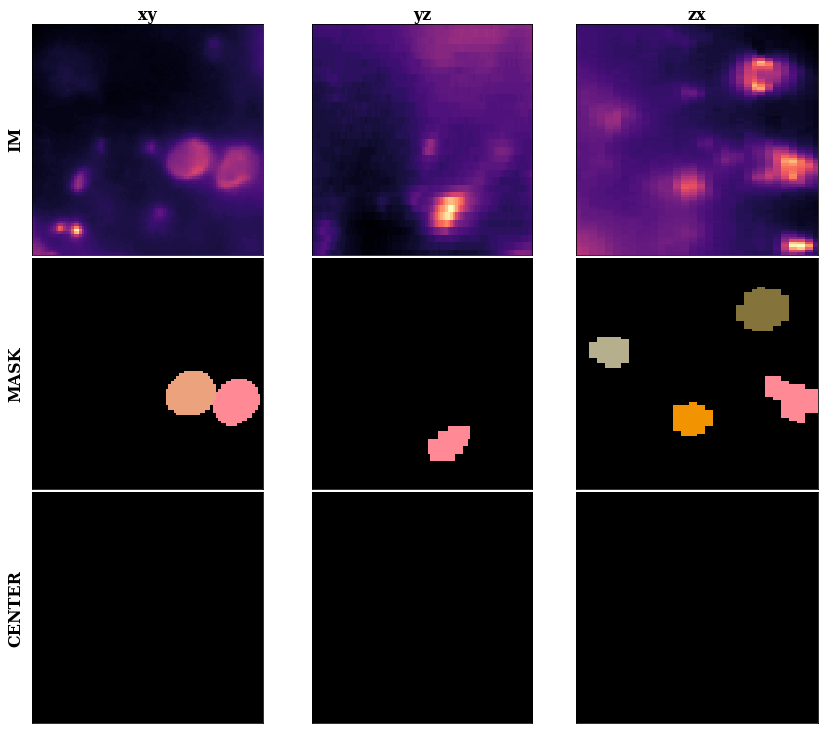

In [13]:
new_cmap = np.load("../../../cmaps/cmap_60.npy")
new_cmap = ListedColormap(new_cmap)  # new_cmap = 'magma' would also work!
visualize_crop_3d(
    data_dir=crops_dir,
    project_name=project_name,
    train_val_dir="train",
    center=center,
    new_cmp=new_cmap,
    anisotropy=anisotropy_factor,
)

In [14]:
crops_dir

'/cluster/project/treutlein/DATA/imaging/EmbedSeg_test/data//3D_Brain_organoids_with_meta/crops_all_06_02_2023_test'